# Random & ExtraTrees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection   import RandomizedSearchCV
import joblib

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Split features/target
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test  = test.drop('Score', axis=1)
y_test  = test['Score']

In [4]:
preprocessor = joblib.load("preprocessor_unfitted.joblib")

## RandomForest pipeline + param distribution

In [5]:
rf_pipe = Pipeline([
    ("prep",  preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

In [6]:
rf_param_dist = {
    "model__n_estimators":     [100, 200],         # only 2 choices
    "model__max_depth":        [None] + list(range(1, 21)),     
    "model__min_samples_split": [2, 5],             # two sensible splits
    "model__min_samples_leaf":  [1, 2],             # small leaf sizes
    "model__bootstrap":         [True]              # drop the False option
}

In [7]:
# RandomizedSearchCV for RandomForestRegressor
rf_search = RandomizedSearchCV(
    estimator          = rf_pipe,
    param_distributions= rf_param_dist,
    n_iter             = 20,
    cv                 = 3,
    scoring            = "neg_mean_squared_error",
    n_jobs             = -1,
    random_state       = 42,
    verbose            = 1
)

In [8]:
print("Searching RandomForestRegressor…")
rf_search.fit(X_train, y_train)

Searching RandomForestRegressor…
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Opening_name',
 

In [9]:
print(f"Best params:", rf_search.best_params_)
print(f"RandomForest best CV MSE: {-rf_search.best_score_:.4f}")
best_rf = rf_search.best_estimator_

Best params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 9, 'model__bootstrap': True}
Lasso best CV MSE: 0.2248


In [11]:
# Final eval on test set
y_pred = best_rf.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.2263
Test MAE: 0.4557
Test R²:  0.0391


[learning_curve] Training set sizes: [  466  2898  5329  7761 10192 12624 15055 17487 19919 22350 24782 27213
 29645 32076 34508 36939 39371 41802 44234 46666]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.8min finished


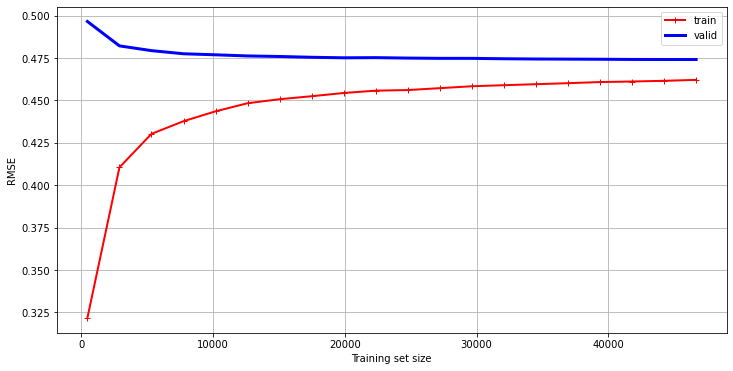

In [14]:
# Plot the learning curve for the RandomForest model
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_rf,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 20),
                                                         cv = 3,
                                                         scoring = "neg_root_mean_squared_error", 
                                                         n_jobs      = -1,
                                                         verbose     = 2 )
                                                            

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [15]:
joblib.dump(best_rf, "best_rf.joblib")

['best_rf.joblib']

## ExtraTrees pipeline + param distribution

In [16]:
et_pipe = Pipeline([
    ("prep",  preprocessor),
    ("model", ExtraTreesRegressor(random_state=42))
])

In [17]:
et_param_dist = {
    "model__n_estimators":     [100, 200],          # just two sizes
    "model__max_depth":        [None] + list(range(1, 21)),      
    "model__min_samples_split": [2, 5],              # two sensible splits
    "model__min_samples_leaf":  [1, 2],              # small leaf sizes
    "model__max_features":      ["sqrt", "log2"]     # drop 'auto' to save one branch
}

In [19]:
#  RandomizedSearchCV with lighter settings
et_search = RandomizedSearchCV(
    estimator           = et_pipe,
    param_distributions = et_param_dist,
    n_iter              = 20,    
    cv                  = 3,     # 3-fold CV instead of 5
    scoring             = "neg_mean_squared_error",
    n_jobs              = -1,
    random_state        = 42,
    verbose             = 2
)

In [20]:
et_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Opening_name',
 

In [21]:
print(f"Best params:", et_search.best_params_)
print(f"ExtraTrees best CV MSE: {-et_search.best_score_:.4f}")
best_et = et_search.best_estimator_

Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 18}
Lasso best CV MSE: 0.2279


In [22]:
# Final eval on test set
y_pred = best_et.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.2284
Test MAE: 0.4619
Test R²:  0.0302


[learning_curve] Training set sizes: [  466  1651  2835  4020  5205  6389  7574  8758  9943 11128 12312 13497
 14681 15866 17051 18235 19420 20604 21789 22974 24158 25343 26527 27712
 28897 30081 31266 32450 33635 34820 36004 37189 38373 39558 40743 41927
 43112 44296 45481 46666]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of 120 | elapsed:   59.6s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


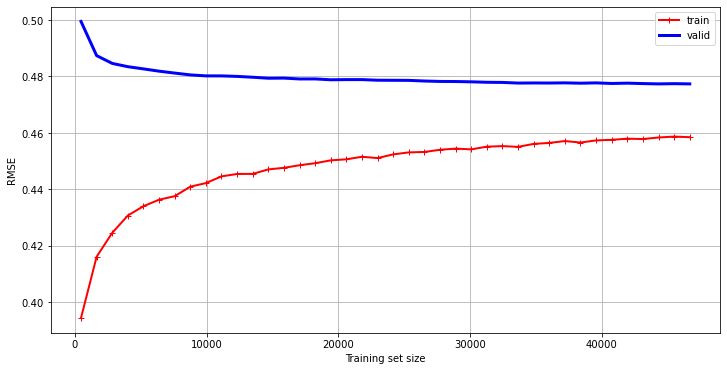

In [23]:
# Plot the learning curve for the ExtraTreesRegressor
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_et,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 40),
                                                         cv = 3,
                                                         scoring = "neg_root_mean_squared_error", 
                                                         n_jobs      = -1,
                                                         verbose     = 2 )

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [24]:
joblib.dump(best_et, "best_et.joblib")

['best_et.joblib']